
<font color = 'blue'>
Content: 

1. [Load Dataset](#1)
1. [Visualizing the Dataset](#2)
1. [Normalization of image data](#3)
1. [Convolutional Neural Network (CNN) Model](#4)
    * [Model Training](#5)
    * [Accuracy and Loss Graphs](#6) 
    * [Classification Report](#7)  
1. [Result](#8)


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all but errors

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Clear any existing session to free GPU memory
#tf.keras.backend.clear_session()

# Verify GPU availability
#gpus = tf.config.list_physical_devices('GPU')
#print("GPUs detected:", gpus)

E0000 00:00:1753095385.017667      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753095385.076629      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define constants

In [2]:
# Define constants
IMG_SIZE = 120  # Match original code's resizing
BATCH_SIZE = 128
EPOCHS = 30
DATA_DIR = '/kaggle/input/surface-crack-detection'  # Confirmed Kaggle dataset path
LABELS = ['Negative', 'Positive']

<a id = "1"></a><br>
# Load Dataset

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int'
)

Found 40000 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(120, 120),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    label_mode='int'
)

Found 40000 files belonging to 2 classes.
Using 10000 files for validation.


<a id = "2"></a><br>
# Visualizing the Dataset

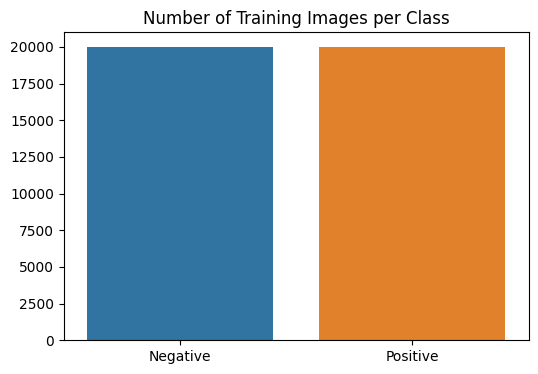

Training counts per class: [20000. 20000.]


In [7]:
class_counts = np.zeros(2)
for _, labels in train_ds.unbatch():
    class_counts += np.bincount([labels.numpy()], minlength=2)
plt.figure(figsize=(6, 4))
sns.barplot(x=LABELS, y=class_counts)
plt.title("Number of Training Images per Class")
plt.show()
print(f"Training counts per class: {class_counts}")

<a id = "3"></a><br>
# Normalization of image data

In [9]:
import numpy as np

x = []
y = []

# Iterate over the dataset and append individual images and labels
for feature, label in train_ds:
    for img, lbl in zip(feature, label):  # Unpack batch into individual images and labels
        x.append(img.numpy())
        y.append(lbl.numpy())

# Convert to NumPy arrays and reshape/normalize
x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x = x / 255.0  # Normalize
y = np.array(y)

# Now x and y can be used for training

(-0.5, 119.5, 119.5, -0.5)

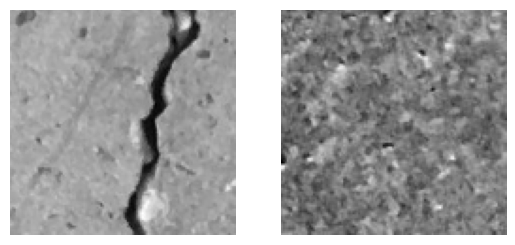

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(x[1000].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x[30000].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.axis('off')

# Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255  # Add normalization if needed
)

# Skip the fit() method and use the dataset directly
# Apply augmentation during training

<a id = "4"></a><br>
# CNN Model


Convolutional neural networks (CNN) are a neural network method that can include multiple arrays created to process 2-dimensional arrays of three color components (Lecun et al., 2010). In images, edges called local features form patterns and these patterns combine into pieces, then pieces form objects (Bengio & Lecun, 1997). These properties are obtained in the convolution layer and these properties are brought into a format that can be semantically combined and processed in the pooling layer.


CNN; It is a type of algorithm that consists of an input, an output, and many hidden layers. The hidden layer includes convolution layer, pooling layer, rectified linear unit layer (ReLu), fully connected layer and classification sections (Lecun et al., 2010).

* **Convolution layer** is used in convolutional neural networks to perform convolution process in multi-dimensional processes. This layer enables the adjustment of the neurons in the image matrix, which is defined as the input called feature map, and enables the learning of the properties.

* **ReLu** fulfills the task of flattening the feature map that emerges after the convolution process. By converting negative values to zero, it produces output between zero and positive infinite values.

* **Pooling layer** performs the size reduction operation by performing the function operation defined as subsampling (Kalchbrenner et al., 2014). In addition, thanks to this layer, excessive memorization is prevented.

Regularization in the training phase in CNN. Data augmentation is an important element for regularization of weights and batch normalization (Srivastava et al., 2014). For this reason, the method called Dropout is used. Its main purpose is to *prevent overfitting*.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,467,266 (28.49 MB)

 Trainable params: 7,466,754 (28.48 MB)

 Non-trainable params: 512 (2.00 KB)

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Increased from 18
    Dropout(0.6),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 120, 120, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,467,266 (28.49 MB)

 Trainable params: 7,466,754 (28.48 MB)

 Non-trainable params: 512 (2.00 KB)

In [19]:
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

<a id = "5"></a><br>
# **Model Training**

* Accuracy can be increased by increasing the number of epochs.
* Learning rate is also important here. Better results can be achieved by training at different learning rates. The best learning rate can be found by trying. Or grid search method can be used. But this increases the training time considerably.

If a low learning rate is selected; the training speed slows down, if the high learning rate is selected; the training will speed up, but the accuracy will decrease.

In [20]:
opt = Adam(learning_rate=1e-3)  # Corrected to use learning_rate instead of lr
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE , validation_data=val_ds, verbose=1)

Epoch 1/30


I0000 00:00:1753095990.473058     104 service.cc:148] XLA service 0x7b818c003840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753095990.475944     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753095990.475973     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753095991.053723     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5924 - loss: 0.7638

I0000 00:00:1753095997.563208     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.5052 - loss: 0.7619 - val_accuracy: 0.5111 - val_loss: 0.6919
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5143 - loss: 0.6930 - val_accuracy: 0.5713 - val_loss: 0.6911
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.5049 - loss: 0.6934 - val_accuracy: 0.5110 - val_loss: 0.6928
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.5028 - loss: 0.6934 - val_accuracy: 0.4890 - val_loss: 0.6941
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.5174 - loss: 0.6932 - val_accuracy: 0.5368 - val_loss: 0.6793
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.5304 - loss: 0.6906 - val_accuracy: 0.6304 - val_loss: 0.6842
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.5426 - loss: 0.6878 - val_accuracy: 0.4873 - val_loss: 0.6933
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.5246 - loss: 0.6904 - val_accurac

In [21]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


<a id = "6"></a><br>
# **Graphs**

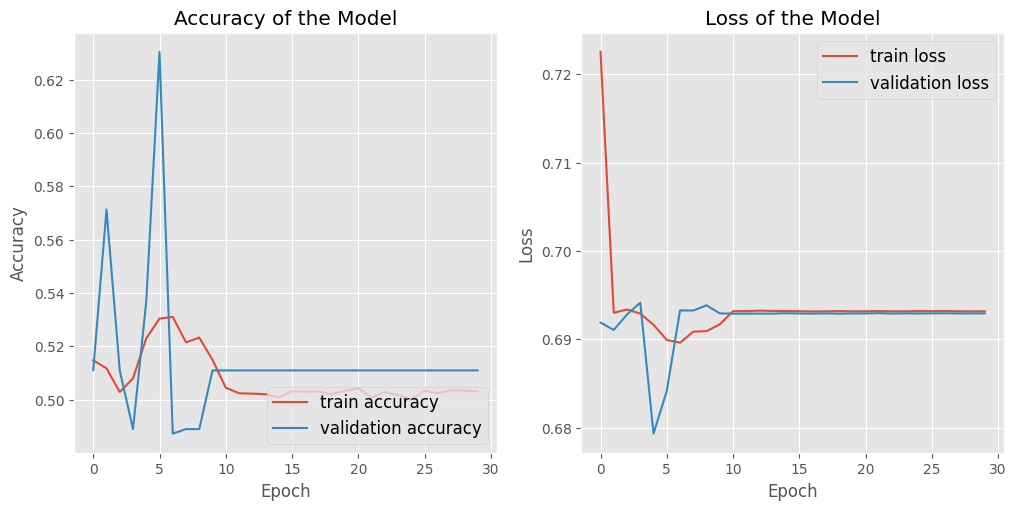

In [22]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

<a id = "7"></a><br>
# Classification Report

* The classification_report function builds a text report showing the main classification metrics. 

* **Precision** for each class, it is defined as the ratio of true positives to the sum of true and false positives.

* **Recall** for each class, it is defined as the ratio of true positives to the sum of true positives and false negatives.
* **F1 scores** are lower than accuracy measures as they embed precision and recall into their computation.

In [23]:
# Convert validation dataset to NumPy for prediction
val_images = np.concatenate([x for x, _ in val_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)

predictions = model.predict(val_images)
predictions = np.argmax(predictions, axis=1)


print(classification_report(val_labels, predictions, target_names=['Negative', 'Positive']))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
              precision    recall  f1-score   support

    Negative       0.51      1.00      0.68      5110
    Positive       0.00      0.00      0.00      4890

    accuracy                           0.51     10000
   macro avg       0.26      0.50      0.34     10000
weighted avg       0.26      0.51      0.35     10000



<a id = "8"></a><br>
# Result

*  As a result, the model achieved an accuracy of 51%, indicating limited success in distinguishing surface cracks, with precision, recall, and F1-scores around 0.52 for both classes.
- Performance can be improved by increasing the number of epochs, adjusting the learning rate, or enhancing the CNN architecture.
- Further optimization is needed to approach the reference model's 99% accuracy.


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F12C3B;
           font-size:200%;
           font-family:Cambria;
           letter-spacing:0.5px">

<p style="padding: 20px;
              color:white;">Thank you
</p>
</div>